In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [2]:
# création d'un tableau pour l'affichage des versions 
table_lib_version = PrettyTable()
table_lib_version.field_names = ["Library", "numpy", "pandas", "seaborn", "tensorflow"]
table_lib_version.add_row(["Version", np.__version__, pd.__version__, sns.__version__, tf.__version__])

print(table_lib_version)

+---------+-------+--------+---------+------------+
| Library | numpy | pandas | seaborn | tensorflow |
+---------+-------+--------+---------+------------+
| Version | 2.1.3 | 2.2.3  |  0.13.2 |   2.19.0   |
+---------+-------+--------+---------+------------+


<div style="background-color: #C7F3A5; padding: 10px;">
    L'objectif principal de ce projet est de développer un réseau de neurones de type <b>perceptrons multi-couches</b> pour la reconnaissance de chiffres manuscrits. Pour cela, nous construirons des différents modèles de réseaux, chacun ayant une configuration distincte, dans le but d'optimiser la précision de la prédiction des chiffres présents dans les images.
    <br><br>
    L'apprentissage supervisé sera effectué sur un ensemble de 60 000 images d'entraînement. Nous évaluerons les performances du modèle en utilisant un échantillon de test composé de 10 000 images. Les images sont en noir et blanc, de dimensions 28 x 28 pixels, et représentent des chiffres écrits à la main.
<hr style="border: 1px solid #000; margin-top: 20px; margin-bottom: 20px;">
    The main objective of this project is to develop a <b>multi-layer perceptron</b> neural network for handwritten digit recognition. To do this, we will build different network models, each with a distinct configuration, aiming to optimize the accuracy of digit predictions from the images.
    <br><br>
    Supervised learning will be performed on a training set of 60,000 images. We will evaluate the model's performance using a test sample of 10,000 images. The images are in black and white, with dimensions of 28 x 28 pixels, representing handwritten digits.
</div>


<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>I. Préparation des données </h1>
</div>

In [3]:
# les données
mnist_train_images = pd.read_csv("../Datasets/mnist_train-e.csv")
mnist_test_images = pd.read_csv("../Datasets/mnist_test-e.csv")

La première colonne du jeu de données contient les labels des chiffres associés à chaque image, que nous séparerons comme cible pour l'entraînement du modèle.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
The first column of the dataset contains the labels of the digits associated with each image, which we will separate as the target for training the model.

In [4]:
# séparation des labels et des images
mnist_train_labels = mnist_train_images.iloc[:, 0]
mnist_test_labels = mnist_test_images.iloc[:, 0]

# suppression de la colonne des labels des ensembles d'images
mnist_train_images = mnist_train_images.drop(columns=[mnist_train_images.columns[0]])
mnist_test_images = mnist_test_images.drop(columns=[mnist_test_images.columns[0]])

Les images <b>mnist</b> sont des images en <i>niveaux de gris</i>, avec des valeurs de pixels comprises entre 0 et 255 (où 0 = blanc, 255 = noir).
Nous allons effectuer une mise à l’échelle entre 0 et 1, en divisant les valeurs par 255. 
En normalisant toutes les images de la même manière, on s’assure que les modèles ne sont pas influencés par des variations d’échelle.
    <br><br>
On crée également un échantillon de validation qui nous permettra par la suite d'éviter l'overfitting, d'optimiser les paramètres et d'évaluer la performance.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
The <b>mnist</b> images are <i>grayscale</i> images, with pixel values ranging from 0 to 255 (where 0 = white, 255 = black).
We will scale the values between 0 and 1 by dividing them by 255.
By normalizing all the images in the same way, we ensure that the models are not influenced by scale variations.
    <br><br>
We also create a validation sample that will later allow us to avoid overfitting, optimize parameters, and evaluate performance.

<figure style="text-align: center;">
    <img src="../Images/ex_img.png" alt="Example Image" width="300">
    <figcaption>Exemple d’imagette 28x28 reproduisant le chiﬀre manuscrit 2 en niveaux de gris</figcaption>
    <figcaption>Example of a 28x28 iamge reproducing the handwritten digit 2 in grayscale</figcaption>
</figure>

In [5]:
# normalisation des pixels (mise à l'échelle entre 0 et 1)
mnist_train_images = mnist_train_images / 255.0
mnist_test_images = mnist_test_images / 255.0

# création de l'échantillon de validation (10% des données d'entraînement)
mnist_train_images, mnist_val_images, mnist_train_labels, mnist_val_labels = train_test_split(
    mnist_train_images, mnist_train_labels, test_size=0.1, random_state=42
)

In [6]:
# création d'un tableau pour l'affichage
table_mnist_shape = PrettyTable()
table_mnist_shape.field_names = ["Dataset", "Images Shape", "Labels Shape"]
table_mnist_shape.add_row(["Train", mnist_train_images.shape, mnist_train_labels.shape])
table_mnist_shape.add_row(["Test", mnist_test_images.shape, mnist_test_labels.shape])
table_mnist_shape.add_row(["Validation", mnist_val_images.shape, mnist_val_labels.shape])

print(table_mnist_shape)

+------------+--------------+--------------+
|  Dataset   | Images Shape | Labels Shape |
+------------+--------------+--------------+
|   Train    | (54000, 784) |   (54000,)   |
|    Test    | (10000, 784) |   (10000,)   |
| Validation | (6000, 784)  |   (6000,)    |
+------------+--------------+--------------+


<h3>Tendances générales</h3>
Nous allons essayer de comprendre commentles pixels des images sont distribués afin d'observer la fréquence des valeurs proches de 0 ou de 1.
<br><br>
Nous allons visualiser la distribution des valeurs des pixels pour plusieurs images choisies de manière aléatoire dans l’ensemble d'entraînement <i>mnist_train_images</i>.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
<h3>General Trends</h3>
We will try to understand how the pixels of the images are distributed in order to observe the frequency of values close to 0 or 1.
<br><br>
We will visualize the distribution of pixel values for several images randomly selected from the training set <i>mnist_train_images</i>.


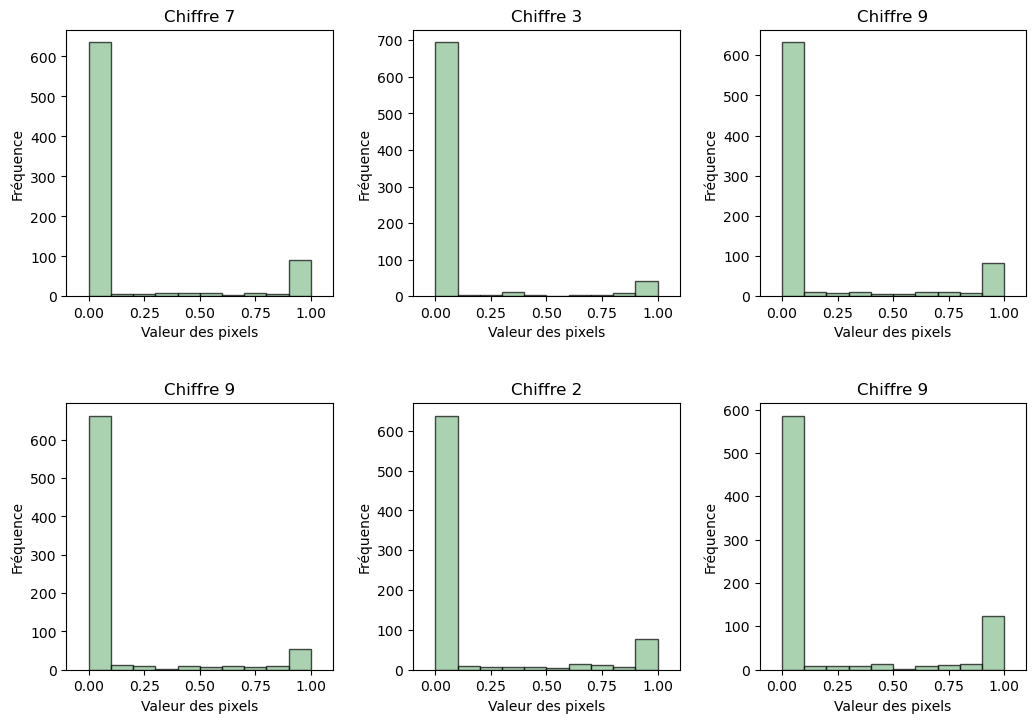

In [7]:
plt.figure(figsize=(12, 8))

for i in range(1, 7):
    idx = np.random.randint(0, mnist_train_images.shape[0])    
    plt.subplot(2, 3, i)    
    plt.hist(mnist_train_images.iloc[idx, :], bins=10, color="#86bf91", edgecolor="black", alpha=0.7)    
    plt.xlim(-0.1, 1.1)    
    plt.title(f"Chiffre {mnist_train_labels.iloc[idx]}", fontsize=12)
    plt.xlabel("Valeur des pixels", fontsize=10)
    plt.ylabel("Fréquence", fontsize=10)
    
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

Nous pouvons observer que, bien qu'il y ait quelques nuances de gris, la majorité des coefficients de pixel sont <b>proches de 0</b>. Cela est compréhensible, car le blanc est représenté par la valeur 0. À l'inverse, quelques pixels présentent des valeurs proches de 1, représentant le noir. Cette distribution des valeurs de pixels reflète la nature des images, où le fond est généralement clair et les chiffres sont représentés par des traits noirs ou sombres.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
We can observe that, although there are some shades of gray, the majority of the pixel coefficients are <b>close to 0</b>. This is understandable, as white is represented by the value 0. On the other hand, a few pixels have values close to 1, representing black. This distribution of pixel values reflects the nature of the images, where the background is typically light and the digits are represented by dark or black strokes.

<h3>Simplification de l'image </h3>
Nous allons réduire la complexité de nos données en <b>réduisant les nuances de gris</b> à seulement deux valeurs. Cette simplification peut aider nos modèles à mieux se concentrer sur la structure essentielle des chiffres, en ignorant les variations plus subtiles dans les nuances de gris.
<br><br>
On décide que les pixels ayant une valeur de nuance de gris inférieure à 0.35 seront transformés en 0 (blanc), et ceux ayant une valeur supérieure ou égale à 0.35 seront transformés en 1 (noir).
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
<h3>Image Simplification</h3>
We will reduce the complexity of our data by <b>reducing the grayscale values</b> to only two values. This simplification can help our models focus better on the essential structure of the digits, ignoring the more subtle variations in the grayscale.
<br><br>
We decide that pixels with a grayscale value lower than 0.35 will be transformed into 0 (white), and those with a value greater than or equal to 0.35 will be transformed into 1 (black).


In [8]:
def reduce_grayscale(data):
    def update_value(x):
        if (x != 0) & (x != 1):
            if x < 0.35: return 0
            else: return 1
        else: return x       
    return data.map(update_value)



In [9]:
# application de la fonction reduce grayscale
datasets = [mnist_test_images, mnist_train_images, mnist_val_images]

mnist_test_images, mnist_train_images, mnist_val_images = [reduce_grayscale(dataset) for dataset in datasets]


On a appliqué le prétraitement aux trois corpus. On peut à présent visualiser les images binarisées prises aux hasard dans le jeu de donnée test.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">

We have applied the preprocessing to all three datasets. We can now visualize the binarized images randomly selected from the test dataset.

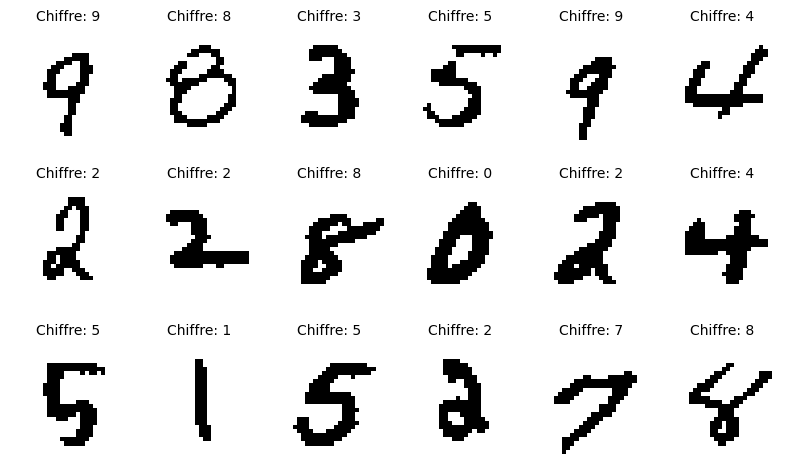

In [10]:
plt.figure(figsize=(8, 5))

for i in range(1, 19):
    a = np.random.randint(0, mnist_test_images.shape[0])
    plt.subplot(3, 6, i)
    plt.imshow(mnist_test_images.iloc[a, :].values.reshape([28, 28]), cmap="gray_r")
    plt.axis("off")
    plt.title(f"Chiffre: {mnist_test_labels.iloc[a]}", fontsize=10, color="black")

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()


Visuellement, les traits du crayon sont trè distincts, ce qui facilite la lecture pour l'œil humain. Cette amélioration sera également bénéfique pour un modèle de perceptron multi-couches. 
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
Visually, the pencil strokes are very distinct, making it easier for the human eye to read. This improvement will also be beneficial for a multilayer perceptron model.

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>II. Préparation d'outils pour évaluer et comparer les modèles </h1>
</div>

In [11]:
def plot_progress(history):
    """
    Trace l'évolution de la perte (loss) et de la précision (accuracy) au cours des epochs d'entraînement.

    Paramètres :
    - history : tensorflow.python.keras.callbacks.History, l'historique de l'entraînement du modèle, obtenu via model.fit().
    
    Retourne :
    - affiche les courbes de loss et d'accuracy pour l'entraînement et la validation.
    """
    
    # extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history.get("val_loss", None)
    accuracy = history.history.get("accuracy", history.history.get("acc", None))
    val_accuracy = history.history.get("val_accuracy", history.history.get("val_acc", None))
    
    epochs = range(1, len(loss) + 1)

    # plot loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, "#F08CAE", label="Train Loss")
    if val_loss:
        plt.plot(epochs, val_loss, "#A0C4E2", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, "#F08CAE", label="Train Accuracy")
    if val_accuracy:
        plt.plot(epochs, val_accuracy, "#A0C4E2", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.show()


In [12]:
def mal_classe(mnist_test_labels, mnist_pred_labels):
    """
    Identifie les indices des images mal classées par le modèle.

    Paramètres :
    - mnist_test_labels : array, les vraies étiquettes des images du jeu de test.
    - mnist_pred_labels : array, les prédictions du modèle sous forme de probabilités (sortie d'un softmax).

    Retourne :
    -list: une liste contenant les indices des images pour lesquelles la prédiction du modèle est incorrecte.
    """
    indices = []
    for i in range(len(mnist_test_labels)):
        if mnist_test_labels[i] != np.argmax(mnist_pred_labels, axis=1)[i] :
            indices.append(i)
    return indices

In [13]:
def plot_image(mnist_test_images, mnist_test_labels, mnist_pred_labels):
    """
    Affiche un échantillon d'images mal classées avec leurs vraies étiquettes et les prédictions du modèle.

    Paramètres :
    - mnist_test_images : pandas.DataFrame, les images du jeu de test sous forme de tableaux (chaque ligne représentant une image aplatie).
    - mnist_test_labels : array-like, les vraies étiquettes des images du jeu de test.
    - mnist_pred_labels : array-like, les prédictions du modèle sous forme de probabilités (sortie d'un softmax).

    Retourne :
    - affiche une figure contenant 18 images mal classées avec leurs étiquettes réelles et prédites.
    """

    plt.figure(2,figsize=(8,9))

    for i in range(1,19):
        a = random_number = np.random.choice(mal_classe(mnist_test_labels, mnist_pred_labels))
        plt.subplot(3,6,i)
        plt.imshow(mnist_test_images.iloc[a,:].values.reshape([28,28]), cmap="gray_r")
        plt.axis("off")
        plt.title("Chiffre : %i" %mnist_test_labels[a] + ", Prédit : %i" %np.argmax(mnist_pred_labels, axis=1)[a])
    plt.subplots_adjust(left = 0.2, bottom = 0.2, right = 1.5, top = 0.6, wspace=0.25, hspace=0.25)
    plt.show()

Afficher la part de bien classée par chiffre en pourcentage.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
 Show the percentage of correct classifications per digit.

In [14]:
def plot_pred(cm):
    """
    Affiche un graphique en barres représentant la précision de classification pour chaque chiffre.

    Paramètres :
    - cm : numpy.ndarray, la matrice de confusion du modèle (confusion matrix), où cm[i, i] représente le nombre de 
                          prédictions correctes pour la classe i.

    Retourne :
    - affiche un graphique en barres indiquant le taux de précision (%) de chaque chiffre.
    """
    # calcul des pourcentages de précision pour chaque chiffre
    pourc = [cm[i, i] / sum(cm[i, :]) for i in range(len(cm))]
    plt.figure(figsize=(8, 5))
    
    plt.bar(range(len(cm)), pourc, color="#86bf91", edgecolor="black", alpha=0.7, width=0.6)
    plt.xlabel("Chiffre", fontsize=12, labelpad=15)
    plt.ylabel("Précision (%)", fontsize=12, labelpad=15)
    plt.title("Justesse de Prédiction des Chiffres", fontsize=16, fontweight="bold", pad=20)
    plt.ylim(top=1.1)
    plt.xticks(np.unique(mnist_test_labels), fontsize=10)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    for i, val in enumerate(pourc):
        plt.text(i, val + 0.03, f"{round(val * 100, 2)}%", ha="center", fontsize=10, color="black", fontweight="bold")
        
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

    plt.tight_layout()
    plt.show()


<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>III. Expérimentation modèles </h1>
</div>

<h3>Premier modèle</h3>

On crée un premier modèle MLP avec une couche cachée. 
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
We create an initial MLP model with one hidden layer. 

In [15]:
model_simple = Sequential()

model_simple.add(Dense(16, kernel_initializer="random_uniform", activation="relu", input_shape=(784,)))
model_simple.add(Dense(10, activation='softmax'))

model_simple.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

trace_simple = model_simple.fit(mnist_train_images, mnist_train_labels, 
                                validation_data=(mnist_val_images, mnist_val_labels), 
                                epochs = 25,
                                batch_size = 32, 
                                verbose = 1)

model_simple.summary()

/Users/saviya/anaconda3/envs/tf_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-04 11:47:06.943079: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-04 11:47:06.943419: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-04 11:47:06.943430: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1743760026.943840 4083050 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743760026.944237 4083050 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0

Epoch 1/25


2025-04-04 11:47:07.783339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8007 - loss: 0.7098 - val_accuracy: 0.9110 - val_loss: 0.3179
Epoch 2/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9094 - loss: 0.3170 - val_accuracy: 0.9178 - val_loss: 0.3011
Epoch 3/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9169 - loss: 0.2967 - val_accuracy: 0.9132 - val_loss: 0.2989
Epoch 4/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9171 - loss: 0.2910 - val_accuracy: 0.9173 - val_loss: 0.2961
Epoch 5/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9186 - loss: 0.2914 - val_accuracy: 0.9142 - val_loss: 0.3033
Epoch 6/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9177 - loss: 0.2938 - val_accuracy: 0.9118 - val_loss: 0.3158
Epoch 7/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9183 - loss: 0.2885 - val_accuracy: 0.9113 - val_loss: 0.3177
Epoch 8/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9202 - loss: 0.2846 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,192 (149.19 KB)

 Trainable params: 12,730 (49.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,462 (99.46 KB)

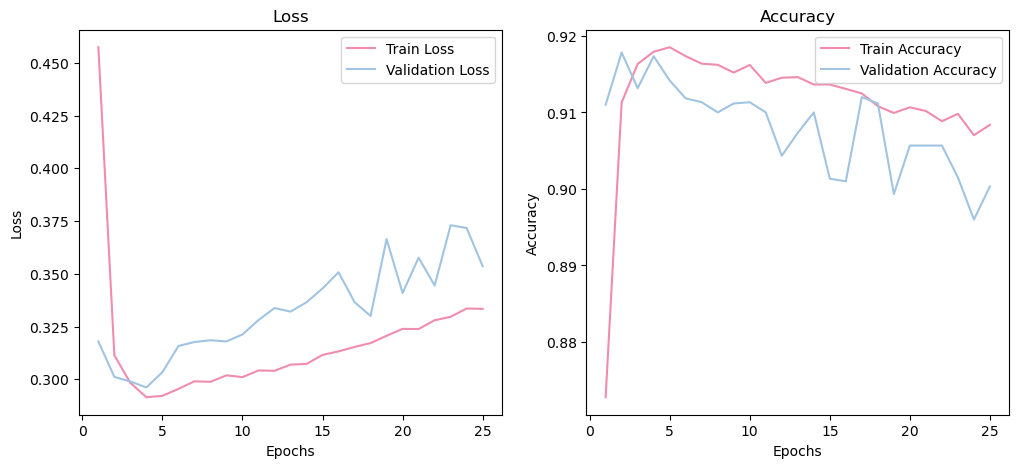

In [16]:
plot_progress(trace_simple)

Le modèle apprend bien au début, mais après quelques epochs, il commence à mémoriser les données d'entraînement plutôt que de généraliser aux nouvelles données.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">
The model learns well at the beginning, but after a few epochs, it starts memorizing the training data instead of generalizing to new data.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


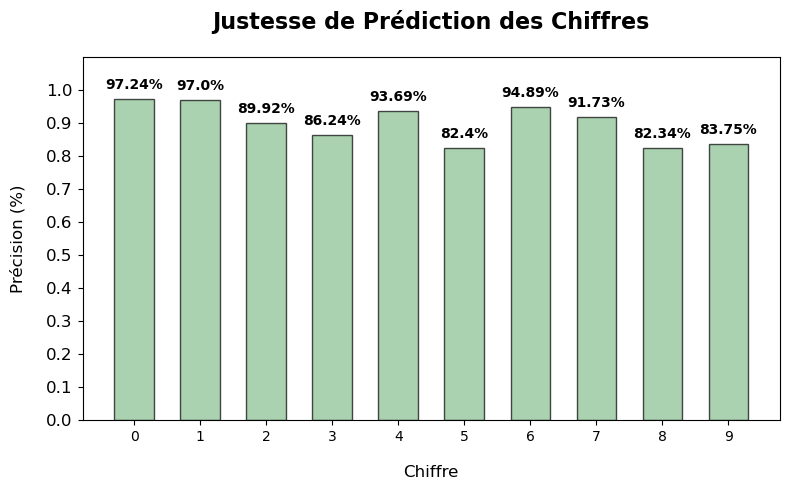

In [17]:
mnist_pred_labels_model_simple = model_simple.predict(mnist_test_images)
cm_simple = confusion_matrix(mnist_test_labels, np.argmax(mnist_pred_labels_model_simple, axis=1))
plot_pred(cm_simple)

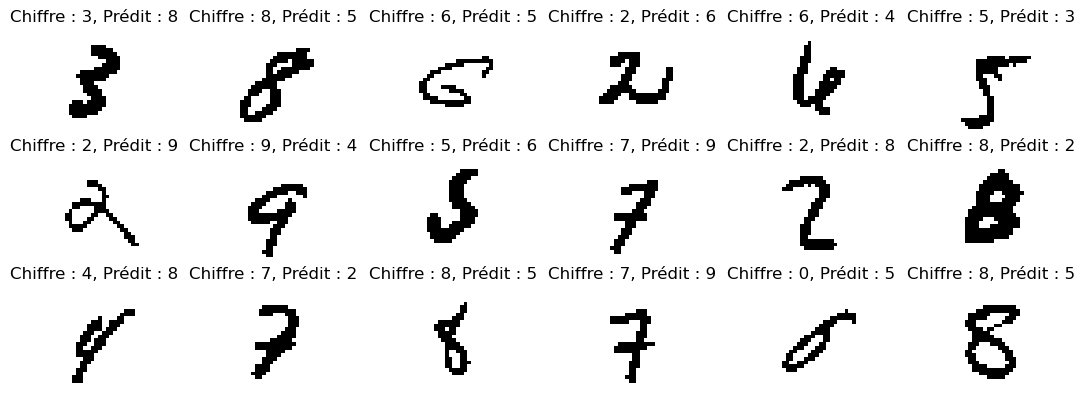

In [18]:
plot_image(mnist_test_images, mnist_test_labels, mnist_pred_labels_model_simple)

D'après ce que nous observons ici, les chiffres qui n'ont pas été prédits sont difficiles à deviner, même pour l'œil humain. Cela dit, le pourcentage de précision des prédictions varie considérablement (de 82 % à 97 %).

Dans l'ensemble, un modèle simple peut être amélioré pour obtenir de meilleurs résultats.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">

Based on what we see here, the digits that were not predicted are hard to guess even for the human eye. That being said, the accuracy percentage of the predictions varies significantly (from 82% to 97%).

Overall, a simple model can be improved for better results.

<h3> Modèle amélioré </h3>

Nous allons intégrer dans le nouveau modèle:
- Deux couches cachées avec 128 et 64 neurones (meilleur compromis entre performance et complexité).
- Pour éviter le surapprentissage on rajoute le <i>dropout</i>
- <i>LeakyReLU</i> au lieu de <i>ReLU</i> (peut mieux gérer les valeurs proches de zéro)
- <i>Batch Normalization</i> pour accélérer l'apprentissage et stabiliser le réseau.
<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">

We will integrate in the new model the following:

- Two hidden layers with 128 and 64 neurons (the best compromise between performance and complexity).
- To prevent overfitting, we add <i>dropout</i>.
- <i>LeakyReLU</i> instead of <i>ReLU</i> (it can handle values close to zero better).
- <i>Batch Normalization</i> to speed up training and stabilize the network.

In [19]:
model_best = Sequential()

model_best.add(Dense(128, kernel_initializer="he_uniform", input_shape=(784,)))
model_best.add(BatchNormalization())  
model_best.add(LeakyReLU(alpha=0.01))  
model_best.add(Dropout(0.3))  

model_best.add(Dense(64, kernel_initializer="he_uniform"))
model_best.add(BatchNormalization())
model_best.add(LeakyReLU(alpha=0.01))
model_best.add(Dropout(0.3))

model_best.add(Dense(10, activation="softmax"))  # Softmax pour classification

model_best.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

trace_best = model_best.fit(mnist_train_images, mnist_train_labels, 
                            validation_data=(mnist_val_images, mnist_val_labels), 
                            epochs=25, 
                            batch_size=32, 
                            verbose=1)

model_best.summary()

/Users/saviya/anaconda3/envs/tf_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/saviya/anaconda3/envs/tf_venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7767 - loss: 0.7470 - val_accuracy: 0.9392 - val_loss: 0.1886
Epoch 2/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.9115 - loss: 0.2999 - val_accuracy: 0.9587 - val_loss: 0.1332
Epoch 3/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.9253 - loss: 0.2423 - val_accuracy: 0.9667 - val_loss: 0.1124
Epoch 4/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.9369 - loss: 0.2057 - val_accuracy: 0.9678 - val_loss: 0.1032
Epoch 5/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.9441 - loss: 0.1850 - val_accuracy: 0.9705 - val_loss: 0.0955
Epoch 6/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9486 - loss: 0.1735 - val_accuracy: 0.9732 - val_loss: 0.0869
Epoch 7/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9516 - loss: 0.1558 - val_accuracy: 0.9717 - val_loss: 0.0845
Epoch 8/25
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9545 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,696 (1.26 MB)

 Trainable params: 109,770 (428.79 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 219,542 (857.59 KB)

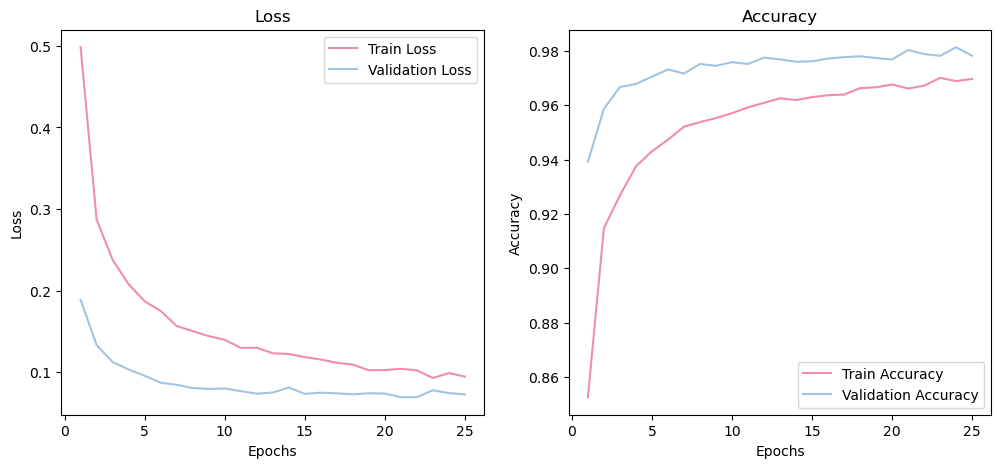

In [20]:
plot_progress(trace_best)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

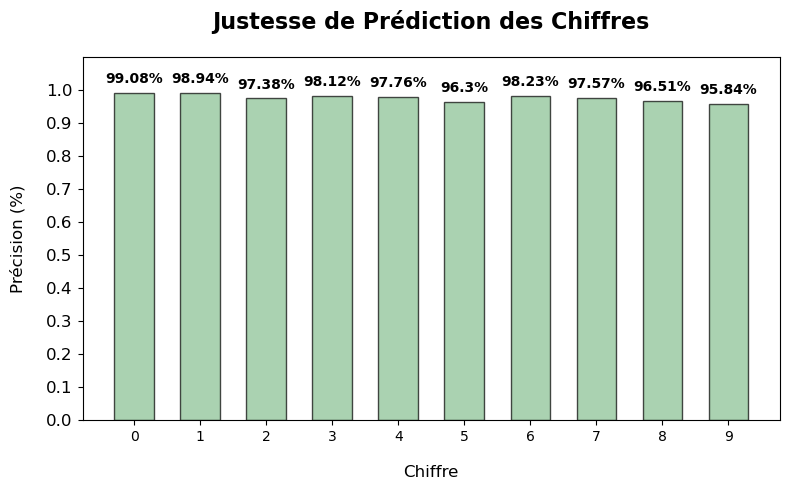

In [21]:
plt.figure(3,figsize=(6,5))
mnist_pred_labels_model_best = model_best.predict(mnist_test_images)
cm_best = confusion_matrix(mnist_test_labels, np.argmax(mnist_pred_labels_model_best, axis=1))
plot_pred(cm_best)

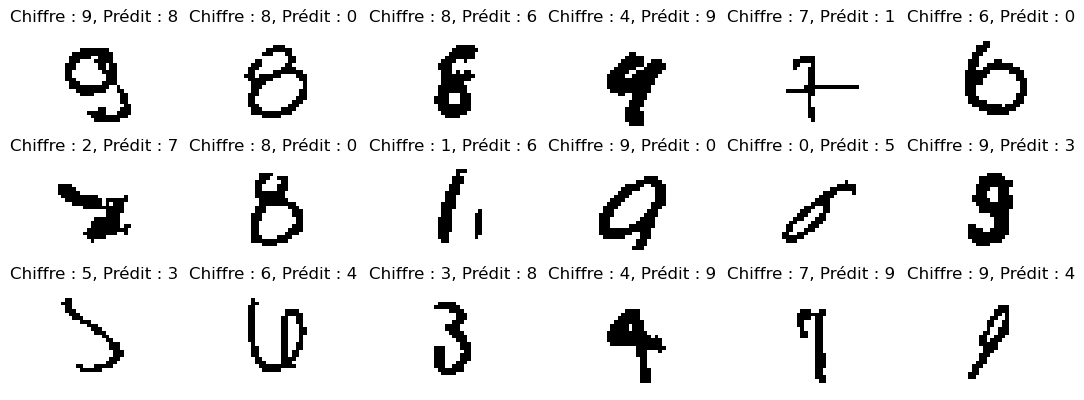

In [22]:
plot_image(mnist_test_images, mnist_test_labels, mnist_pred_labels_model_best)

<div style="background-color: #F6BDD1; color:white; padding: 10px;">
    <h1>IV. Conclusion </h1>
</div>

Nous avons montré qu’un simple MLP peut atteindre de bonnes performances (~95-99%) sur MNIST. L'ajout de techniques de régularisation et d’optimisation permet d'améliorer significativement les résultats, mais il reste encore des axes d'amélioration possibles pour obtenir un modèle encore plus robuste et performant. 

L'ajustement des hyperparamètres peut considérablement améliorer les performances. 

Il existe également d'autres architectures comme les réseaux de neurones convolutifs qui sont beaucoup plus efficaces pour la reconnaissance d'images. Contrairement aux MLP, qui traitent chaque pixel indépendamment, les CNNs capturent mieux les motifs spatiaux.

<hr style="border: 1px solid #000; margin-top: 5px; margin-bottom: 5px;">

We have shown that a simple MLP can achieve good performance (~95-99%) on MNIST. The addition of regularization and optimization techniques significantly improves the results, but there are still areas for improvement to obtain a more robust and efficient model.

Tuning hyperparameters can significantly enhance performance.

There are also other architectures, such as convolutional neural networks (CNNs), which are much more effective for image recognition. Unlike MLPs, which process each pixel independently, CNNs better capture spatial patterns.